In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Abnormal(Covid)','Normal']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/chest_xray_dataset3200/train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1130/1130 [00:15<00:00, 73.56it/s] 


In [5]:
X_train.shape

(3200, 224, 224, 3)

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

Model Build

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D, Dense
 
def conv_batchnorm_relu(x, filters, kernel_size, strides):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
 
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)
 
    x = Add()([x, tensor])
    x = ReLU()(x)
    return x
 
 
def projection_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=strides)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)
 
    # right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)  # notice: filters=4*filters
    shortcut = BatchNormalization()(shortcut)
 
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x
 
 
def resnet_block(x, filters, reps, strides):
    x = projection_block(x, filters=filters, strides=strides)
    for _ in range(reps-1):  # the -1 is because the first block was a Conv one
        x = identity_block(x, filters=filters)
    return x
 
 
input = Input(shape=(224, 224, 3))
 
x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)  # [3]: 7x7, 64, strides 2
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # [3]: 3x3 max mool, strides 2
 
x = resnet_block(x, filters=64, reps=3, strides=1)
x = resnet_block(x, filters=128, reps=4, strides=2)  # s=2 ([2]: conv3_1)
x = resnet_block(x, filters=256, reps=6, strides=2)  # s=2 ([2]: conv4_1)
x = resnet_block(x, filters=512, reps=3, strides=2)  # s=2 ([2]: conv5_1)
 
x = GlobalAvgPool2D()(x)  # [3]: average pool *it is not written any pool size so we use Global
 
output = Dense(2, activation='softmax')(x)  # [3]: 1000-d fc, softmax
 
from tensorflow.keras import Model
 
model = Model(input, output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [13]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DenseNet121.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [14]:
history = model.fit(X_train,y_train,validation_split=0.05, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.9309
Epoch 1: val_accuracy improved from -inf to 0.67361, saving model to DenseNet121.h5
86/86 [==============================] - 48s 375ms/step - loss: 0.3081 - accuracy: 0.9309 - val_loss: 14.6257 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9653
Epoch 2: val_accuracy did not improve from 0.67361
86/86 [==============================] - 29s 333ms/step - loss: 0.1370 - accuracy: 0.9653 - val_loss: 0.9282 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9700
Epoch 3: val_accuracy did not improve from 0.67361

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
86/86 [==============================] - 29s 335ms/step - loss: 0.1058 - accuracy: 0.9700 - val_loss: 0.8161 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 4/50
86/86 [=

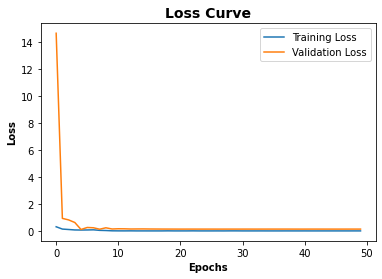

In [15]:
#plot the loss curve
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.ylabel('Loss',fontweight='bold')
plt.title('Loss Curve',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
plt.savefig('Covid_ResNet50_LossCurve',dpi=400)
plt.legend()

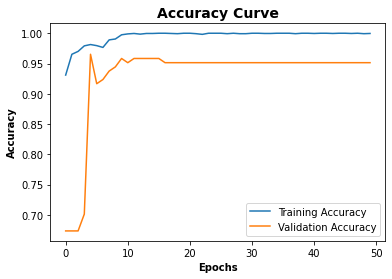

In [16]:
#plot the accuracy curve
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Accuracy Curve',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
plt.savefig('Covid_ResNet50_AccCurve',dpi=400)
plt.legend()

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 2s 100ms/step


In [18]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       210
           1       0.98      0.99      0.99       110

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



In [19]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


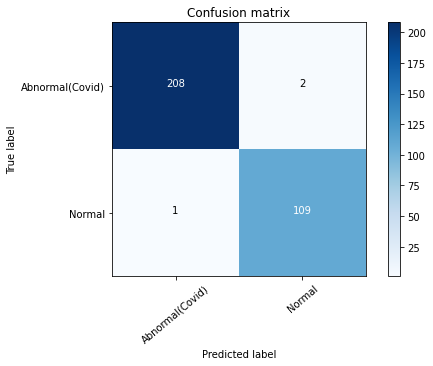

In [20]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('Covid_ResNet50CM',dpi=400)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.5f' % accuracy_score(y_test_new, pred), 'Precision: %.5f' % precision_score(y_test_new, pred),' Recall: %.5f' % recall_score(y_test_new, pred), 
      'F1 Score: %.5f' % f1_score(y_test_new, pred), 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.99062 Precision: 0.98198  Recall: 0.99091 F1 Score: 0.98643 AUC Score: 0.99069


In [22]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [23]:
print('TP = %.5f'%TP, 'TN = %.5f'%TN, 'FP = %.5f'%FP, 'FN = %.5f'%FN)

TP = 109.00000 TN = 208.00000 FP = 2.00000 FN = 1.00000


In [24]:
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)

 Recall: 0.99091
 Precision: 0.98198


In [25]:
f1=(2*precision*recall)/(recall+precision)

In [26]:
print('F1 Score: %.5f' % f1)

F1 Score: 0.98643


In [27]:

print( 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

AUC Score: 0.99069


In [28]:
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))

Error Rate: 0.00937


In [29]:
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)

Specificity: 0.99048


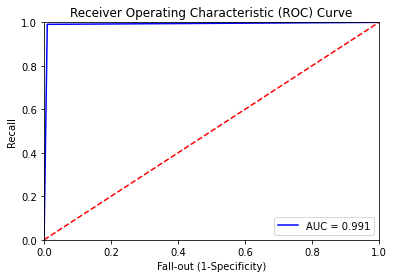

In [34]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.savefig('Covid_ResNet50_AUC',dpi=400)
plt.show()

In [31]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))
print('val_accuracy: {0:0.2f}%'.format(np.round((history.history['val_accuracy'][-1])*100, 2)))

Accuracy: 99.06%
Precision: 98.20%
Recall or Sensitivity: 99.09%
Specificity: 99.05%
F1-score: 98.64%
AUC-score: 99.07%
Train acc: 99.96%
val_accuracy: 95.14%


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score
from scipy import interp
from itertools import cycle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


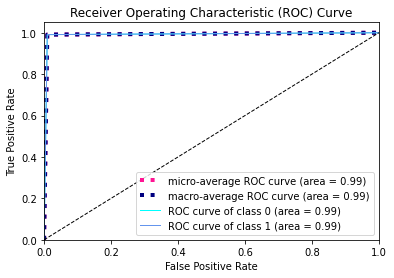

In [33]:
# Plot linewidth.
lw = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_new, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('Covid_ResNet50_ROC',dpi=400)
plt.show()